In [148]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from ast import literal_eval
import json

In [149]:
file_name = "9M-5-[1-2001]-[a]-lcm.out"
output_file = f"queries_results/python_{file_name.replace('out','csv')}"

In [150]:
encoder = LabelEncoder()
encoder.classes_ = np.load(f'../../plots/encoders/{file_name}.npy')

def partial_df():
    # Groupes over two periods only
    links = pd.read_csv(f"../../plots/links/{file_name}")
    links["user_id"] = links["user_id"].apply(lambda x : x.split()).apply(set)
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    groups["user_ids"] =  groups["user_ids"].apply(literal_eval)
    return links.merge(groups.reset_index(),left_on="source",right_on='index').merge(groups.reset_index(),left_on="target",right_on='index')

def full_df():
    # Groups over three periods only
    links = pd.read_csv(f"../../plots/links/{file_name}")
    links["user_id"] = links["user_id"].apply(lambda x : x.split()).apply(set)
    groups = pd.read_csv(f"../../plots/groups/{file_name}",index_col=0)
    groups.drop(["itemset_name","property_values"],axis=1,inplace=True)
    groups = groups.drop(['depth',"a","size","support",],axis=1)
    groups["itemsets"] = groups["itemsets"].apply(lambda x :set(encoder.inverse_transform([int(i) for i in x.split()])))
    groups["user_ids"] =  groups["user_ids"].apply(literal_eval).apply(set)
    
    groups = groups.reset_index() 
    links = links.merge(links,left_on="target",right_on="source")
    links = links.merge(groups[["itemsets","index"]],left_on="source_x",right_on="index")
    links = links.merge(groups[["itemsets","index"]],left_on="target_x",right_on="index")
    links = links.merge(groups[["itemsets","index"]],left_on="target_y",right_on="index")
    links.drop(["source_y","index","index_x","index_y"],axis=1,inplace=True)
    links = links.rename(columns={"itemsets":"itemsets_z","target_y":"target_z"})
    links["user_id_z"] = links.apply(lambda x : x["user_id_x"].intersection(x["user_id_y"]),axis=1)
    return links

def promotion_query(x,query_name):
    if x["period_x"] == before_promo_period and x["period_y"]== promo_period: # _x => T-1 , _y => T 
        if query_name =="adoption":
            return x["itemsets_y"].difference(x["itemsets_x"])
        if query_name =="loyalty1":
            return x["itemsets_y"].intersection(x["itemsets_x"])
    if x["period_x"]== promo_period and x["period_y"]== after_promo_period: # _x => T , _y => T+1 
        if query_name =="loyalty2":
            return x["itemsets_y"].intersection(x["itemsets_x"])
    return set()

with open("../../datasets/Total/ids_mapping.json","r") as file:
    mapping = json.load(file)



# Product adoption & Loyalty

In [158]:
%timeit df = partial_df()

101 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [165]:
df.shape

(569, 11)

T-1, T and T+1

In [166]:
before_promo_period = df.period_x.min()
after_promo_period = df.period_y.max()
promo_period = list(set(df.period_x.unique()).difference((before_promo_period,after_promo_period)))[0]
print(f"T-1 : {before_promo_period}")
print(f"T : {promo_period}")
print(f"T+1 : {after_promo_period}")

T-1 : 2018-09-01
T : 2018-12-01
T+1 : 2019-02-01


# Queries execution

In [167]:
%timeit df["adopted_products"] = df.apply(lambda x: promotion_query(x,"adoption"),axis=1)

19.2 ms ± 977 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [168]:
%timeit df["loyalty1"] = df.apply(lambda x: promotion_query(x,"loyalty1"),axis=1)

21.9 ms ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [169]:
%timeit df["loyalty2"] = df.apply(lambda x: promotion_query(x,"loyalty2"),axis=1)

23.3 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [170]:
df.to_csv(output_file)

In [171]:
items = pd.read_csv("../../datasets/Total/items.csv",index_col=0)
items.ARTICLE_ID.astype(str).replace(mapping,inplace=True)
items.drop(["IDS_LIST"],axis=1,inplace=True)
items.set_index("ARTICLE_ID",inplace=True)

items["adoption_counts"]=0
items["loyalty1_counts"]=0
items["loyalty2_counts"]=0


adoption_counts,loyalty1_counts,loyalty2_counts= [],[],[]
for i,j,k in zip(df.adopted_products.values.tolist(),df.loyalty1.values.tolist(),df.loyalty2.values.tolist()):
    if i!=set():
        adoption_counts+= list(i) 
    if j!=set():
        loyalty1_counts += list(j)
    if k!=set():
        loyalty2_counts += list(k)
adoption_counts, loyalty1_counts,loyalty2_counts = Counter(adoption_counts),Counter(loyalty1_counts),Counter(loyalty2_counts)


for i in adoption_counts:
    items.loc[int(i),"adoption_counts"] = adoption_counts[i]
for j in loyalty1_counts:
    items.loc[int(j),'loyalty1_counts'] = loyalty1_counts[j]
for j in loyalty2_counts:
    items.loc[int(j),'loyalty2_counts'] = loyalty2_counts[j]
    
items = items.sort_values(by=items.columns[-2:].tolist(),ascending=False)
items

,DESCRIPTION,adoption_counts,loyalty1_counts,loyalty2_counts
ARTICLE_ID,,,,
3425909001007,RECHARGE LAVAGE TW - A,96,21,29
3425909002011,RECHARGE LAVAGE TW - D,91,7,11
3425901018140,BIDON AD BLUE 10L,28,2,2
3425901028170,QUARTZ IN LG LIFE 5W30,15,0,1
3019081236250,1 6 RILLETTES THON 125G,0,0,0
...,...,...,...,...
3700619604725,ZIGOH DESO FLEUR FUSHIA,0,0,0
3103220009055,ZIGOTO REGLISSE,0,0,0
3700300542008,ZIP AMIS LUDENDO,0,0,0


In [181]:
%timeit df = full_df()

853 ms ± 36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [184]:
df.shape

(28339, 12)

In [185]:
%timeit df["loyalty"] = df.apply(lambda x :x["itemsets_x"].intersection(x["itemsets_y"].intersection(x["itemsets_z"])),axis=1)

1.08 s ± 40.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [186]:
%timeit df["promo_exclusive_products"] = df.apply(lambda x : x["itemsets_y"].difference(x["itemsets_x"]).difference(x["itemsets_z"]),axis=1)

1.08 s ± 40.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [187]:
%timeit df["replacement"] = df.apply(lambda x : x["itemsets_x"].intersection(x["itemsets_y"]).difference(x["itemsets_z"]),axis=1)

1.03 s ± 39.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


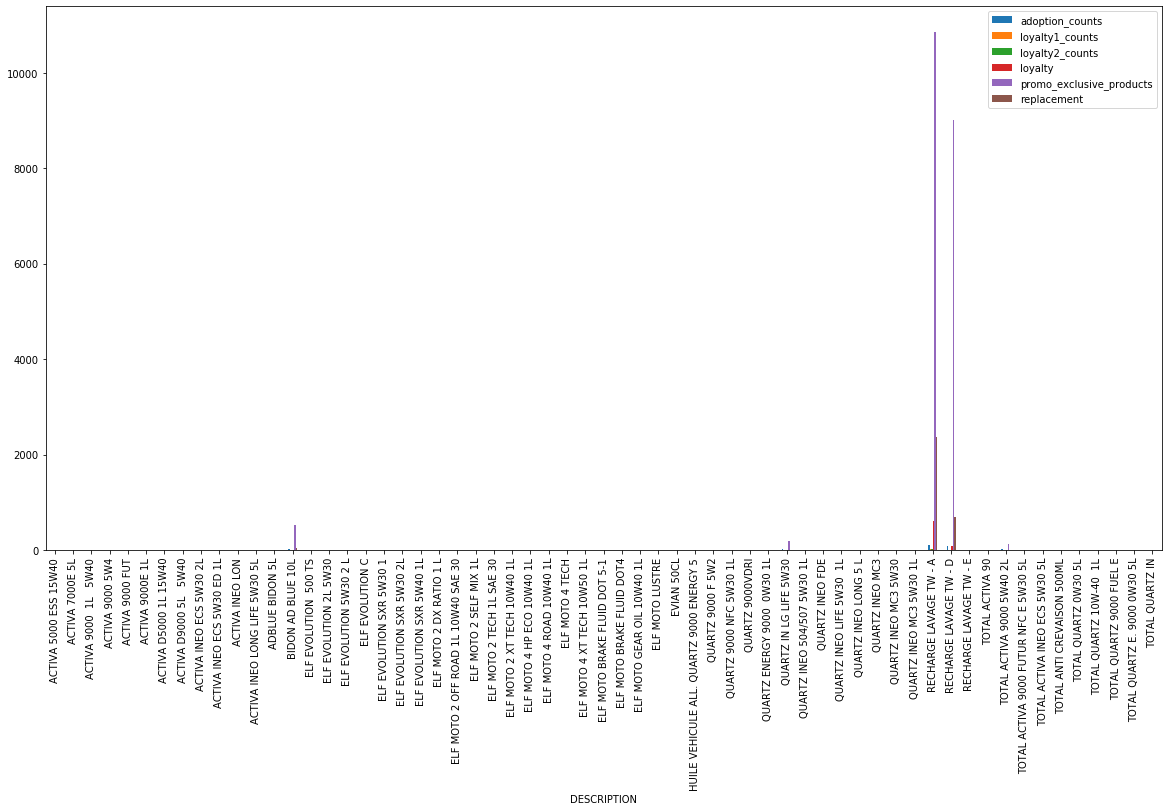

In [188]:
querys_names = ["loyalty","promo_exclusive_products","replacement"]
for i in querys_names:
    items[i]=0
def get_stats(x,columns = querys_names,items=items):
    for i in columns:
        if len(x[i])>0:
            items.loc[x[i],i]+=1
df.apply(get_stats,axis=1)
promo_ids = pd.read_csv("../../datasets/Total/promo_products.csv").ARTICLE_ID.unique()
items.loc[promo_ids].plot(x="DESCRIPTION", y=items.columns[1:], kind="bar",figsize=(20,10))

In [189]:
items.to
items.loc[promo_ids].sort_values(by=["adoption_counts"],ascending=False)

,DESCRIPTION,adoption_counts,loyalty1_counts,loyalty2_counts,loyalty,promo_exclusive_products,replacement
ARTICLE_ID,,,,,,,
3425909001007,RECHARGE LAVAGE TW - A,96,21,29,609,10848,2373
3425909002011,RECHARGE LAVAGE TW - D,91,7,11,77,9009,693
3425901018140,BIDON AD BLUE 10L,28,2,2,4,532,38
3425901018720,TOTAL ACTIVA 9000 5W40 2L,15,0,0,0,120,0
3425901028170,QUARTZ IN LG LIFE 5W30,15,0,1,0,180,0
...,...,...,...,...,...,...,...
3267021030530,ELF MOTO 2 XT TECH 10W40 1L,0,0,0,0,0,0
3267021020531,ELF MOTO 4 HP ECO 10W40 1L,0,0,0,0,0,0
3267025007361,ELF MOTO 4 ROAD 10W40 1L,0,0,0,0,0,0
